# Watershed Algorithm

The watershed treats the image as a topographic map. Useful for image segmentation!

## How It Works

Identify *High Intensity* peaks as hills, while *Low Intensity* denotes valleys.

The algorithm than fill this local values with labels, when the values aproximate (merges) it create bondories.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def display(img, cmap="gray"):
    fig = plt.figure(figsize=(15,15))
    subplot = fig.add_subplot(111)
    subplot.imshow(img,cmap)

## The Coin Problem

Imagine we have a grid of coins touching each other and we need to identify each one of the coins. How we could do that?

### The Blur/Threshold/Contour Solution

With the knowlege we've so far the only option would be apply a pipeline of image techniques to separe the coins like:

blur -> grayscale -> threshold -> contour

__SPOILER:__ This will not work!

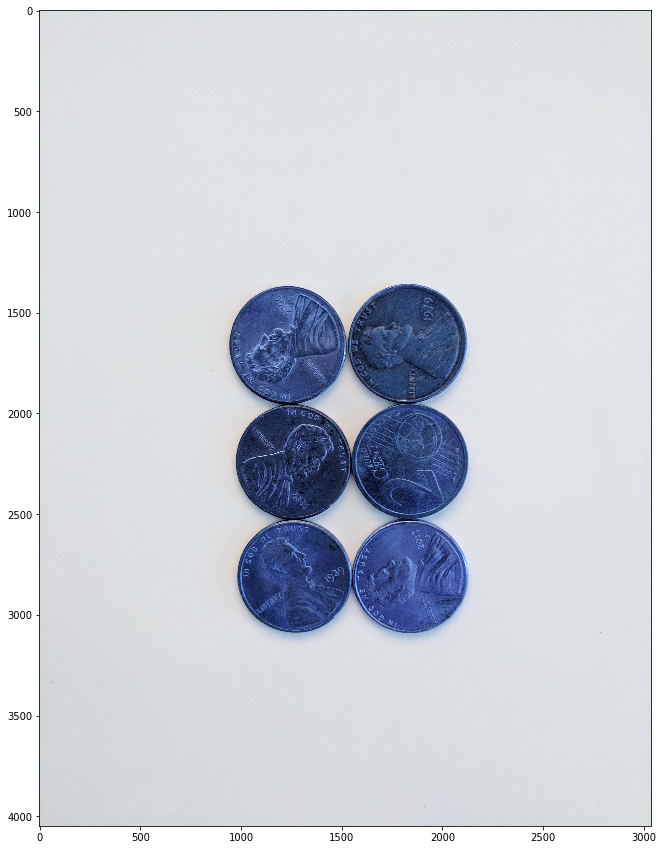

In [4]:
coins_img = cv.imread("../assets/pennies.jpg")
display(coins)

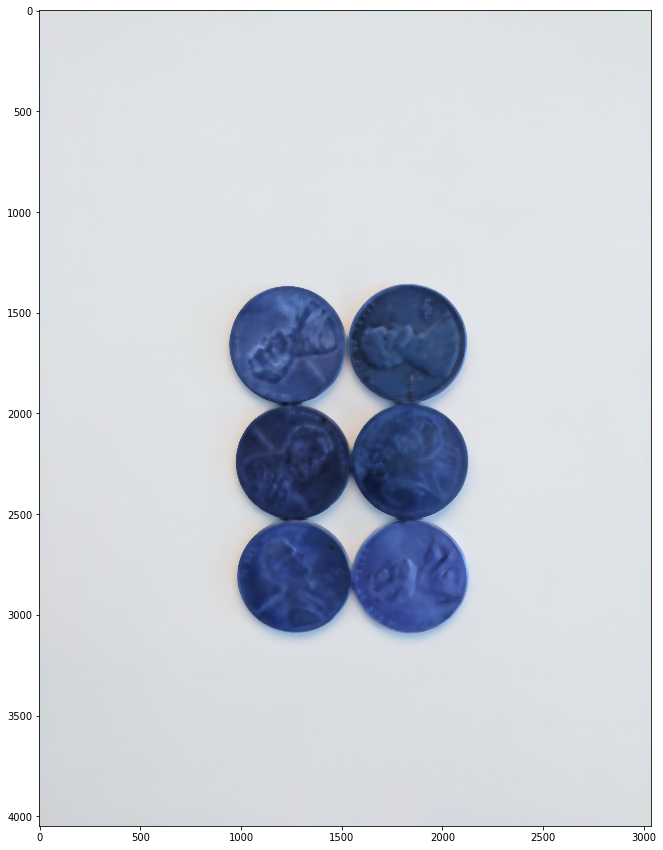

In [5]:
coins_blur = cv.medianBlur(coins_img, 25)
display(coins_blur)

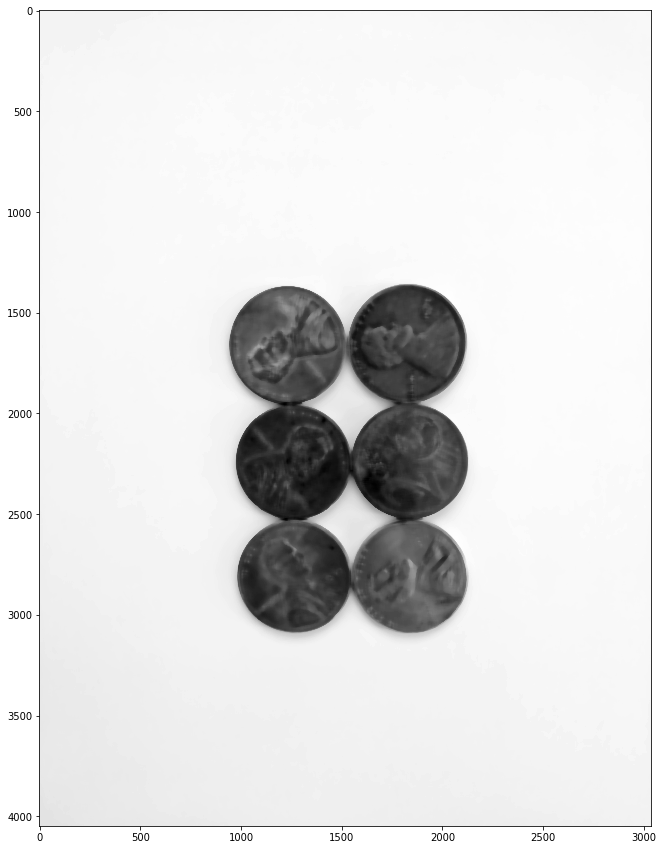

In [6]:
gray_coins_img = cv.cvtColor(coins_blur, cv.COLOR_BGR2GRAY)
display(gray_coins_img)

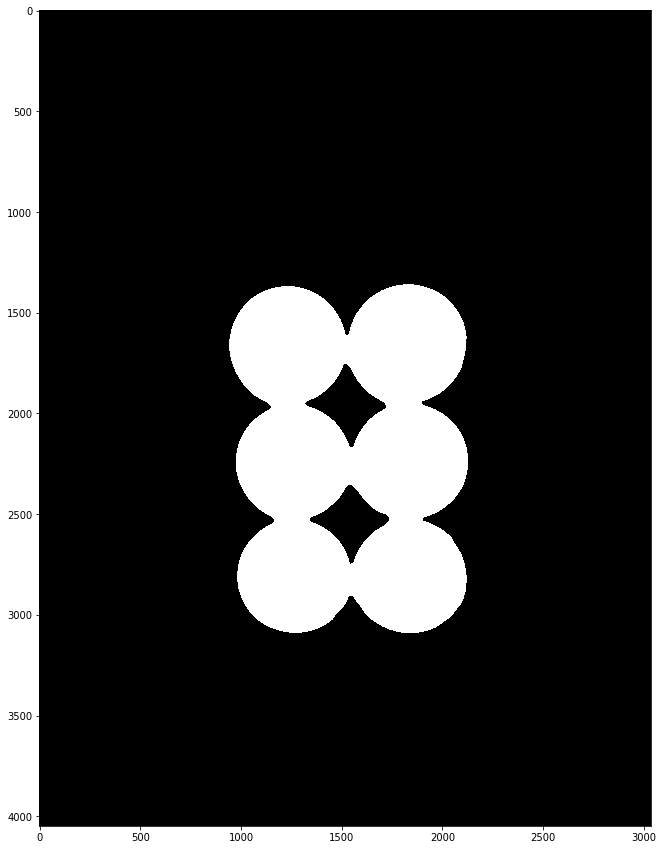

In [8]:
ret, coins_threshold = cv.threshold(gray_coins_img, 160,255,cv.THRESH_BINARY_INV)
display(coins_threshold)

In [11]:
# in openCv 4 is only 2 -> contours, hierarchy
image, contours, hierarchy = cv.findContours(coins_threshold.copy(), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

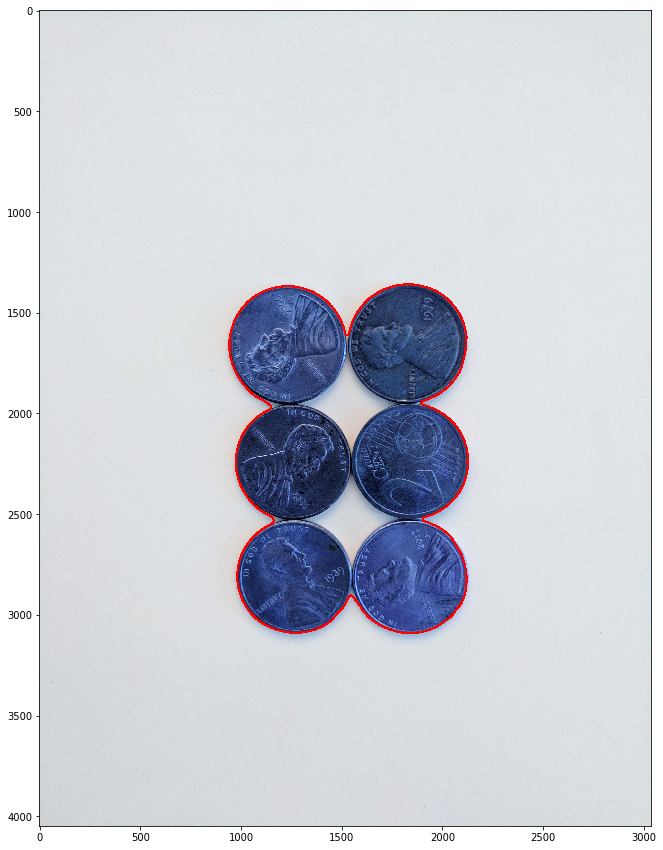

In [12]:
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv.drawContours(coins_img, contours, i, (255,0,0), 10)
display(coins_img)

### The Watershed Solution

Similar to the last solution, we will use a pipeline of image processing, but it's a more complex one:

1. Apply a strong **blur**, remove all image details

1. Convert to **grayscale**

1. Apply **threshold**, with BIN_INVERTED+OTSU

1. Apply **noise reduce**

1. Find the Sure Forground
    1. Apply **distance transformation**
    1. Apply **threshold**

1. Find the Sure Background 
    1 Apply **dilatetion**
    
1. Apply the Watershed
    1. **Subtract** Sure Background from Sure Forground
    1. Apply **connectedComponents**
    1. Apply **Watershed**

1. Apply **Contour**

__SPOILER:__ It works!

In [14]:
coins_img = cv.imread("../assets/pennies.jpg")

#### Apply Blur

It will hide the coin details

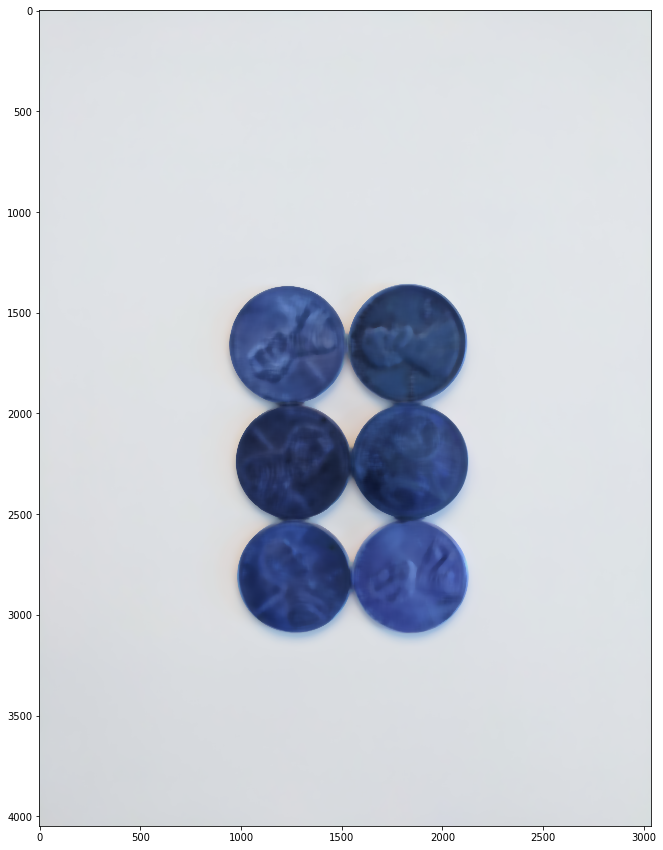

In [17]:
coins_blur = cv.medianBlur(coins_img, 35)
display(coins_blur)

#### Convert to Grayscale

It will make things easier

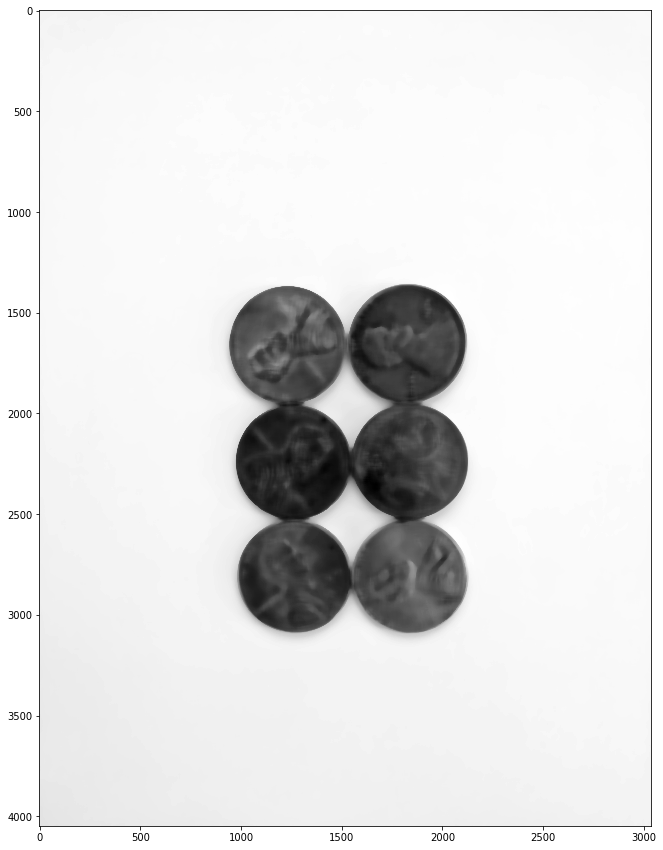

In [18]:
gray_coins_img = cv.cvtColor(coins_blur, cv.COLOR_BGR2GRAY)
display(gray_coins_img)

#### Apply Threshold (Otsu)

Otsu's Method A kind of threshold that works nice with watershed algorithms

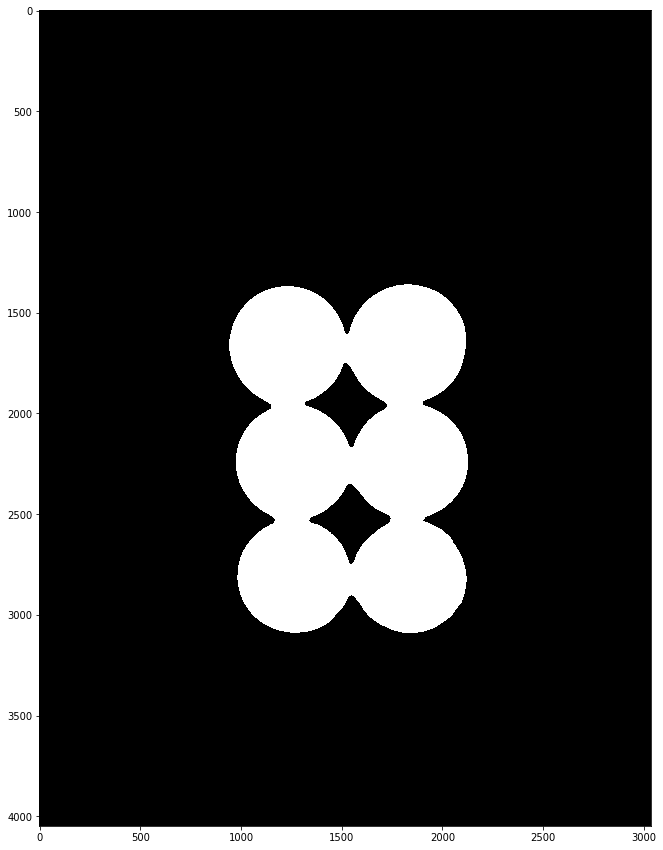

In [21]:
ret, coins_threshold = cv.threshold(gray_coins_img, 160,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
display(coins_threshold)

#### Remove The Noise

In this image we are working with is an absolute overkill (not necessery), but in most Hi-res images it will be a necessery step!

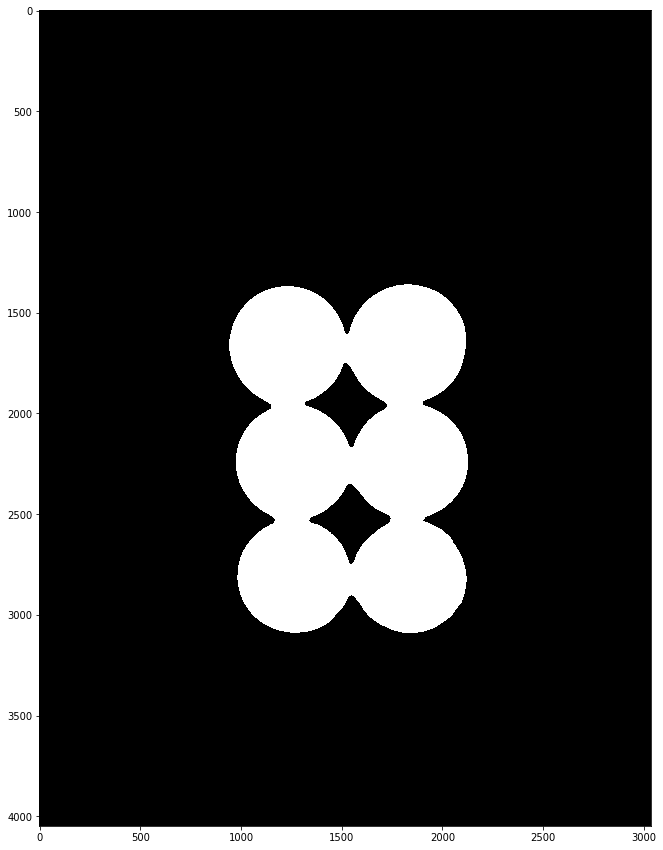

In [23]:
kernel = np.ones((3,3), np.uint8)
opening_img = cv.morphologyEx(coins_threshold, cv.MORPH_OPEN, kernel, iterations=2)
display(opening_img)

#### Distance Transform

As pixels are further away from 0 they become brighter!

[More info here!](https://en.wikipedia.org/wiki/Distance_transform)


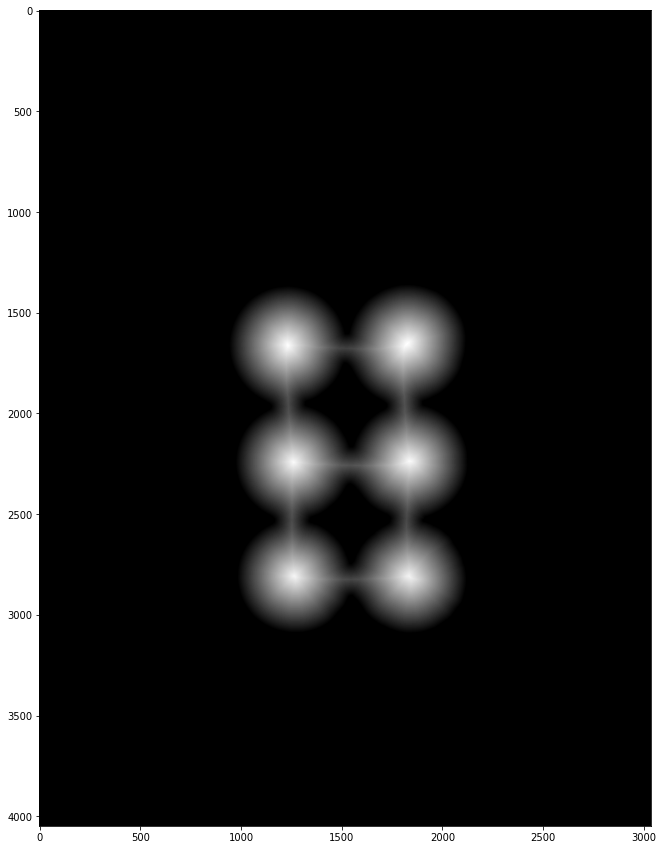

In [25]:
coins_distance_transform = cv.distanceTransform(opening_img, cv.DIST_L2, 5)
display(coins_distance_transform)

#### Apply Second Threshold

To get the center points as clear as possible


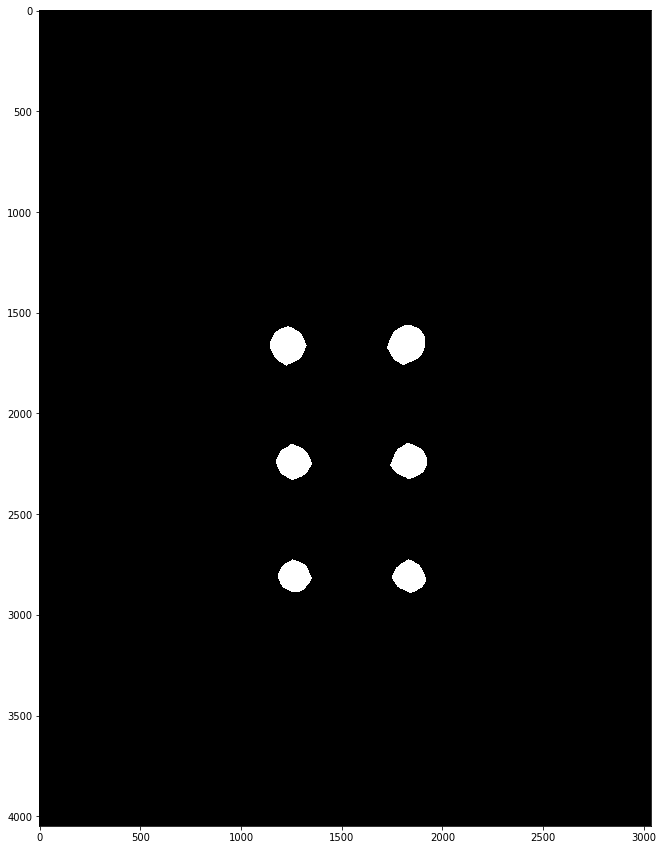

In [29]:
ret, coins_threshold_2 = cv.threshold(coins_distance_transform, 0.7*coins_distance_transform.max(), 255,cv.THRESH_BINARY)
display(coins_threshold_2)

#### Apply The Watershed

Whatever is not in threshold_2 (foreground) but is in threshold_1 (background), is the unkown region!

We need the watershed to discovery this!

##### 1. Find the unkown region

In [41]:
coins_foreground = np.uint8(coins_threshold_2.copy())
coins_background = cv.dilate(opening_img,kernel,iterations=2)

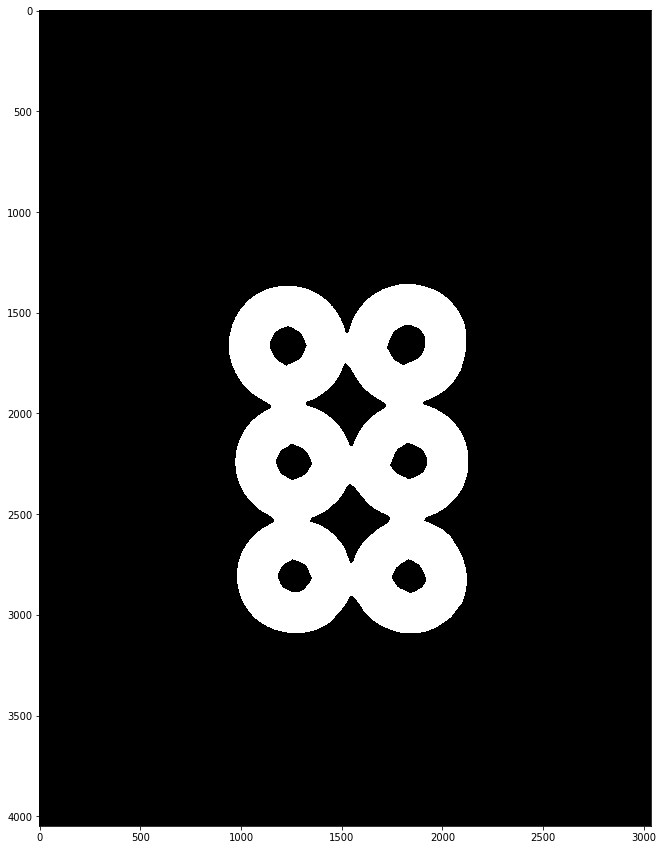

In [42]:
unkown_area = cv.subtract(coins_background, coins_foreground)
display(unkown_area)

##### 2. Create the seeds markers

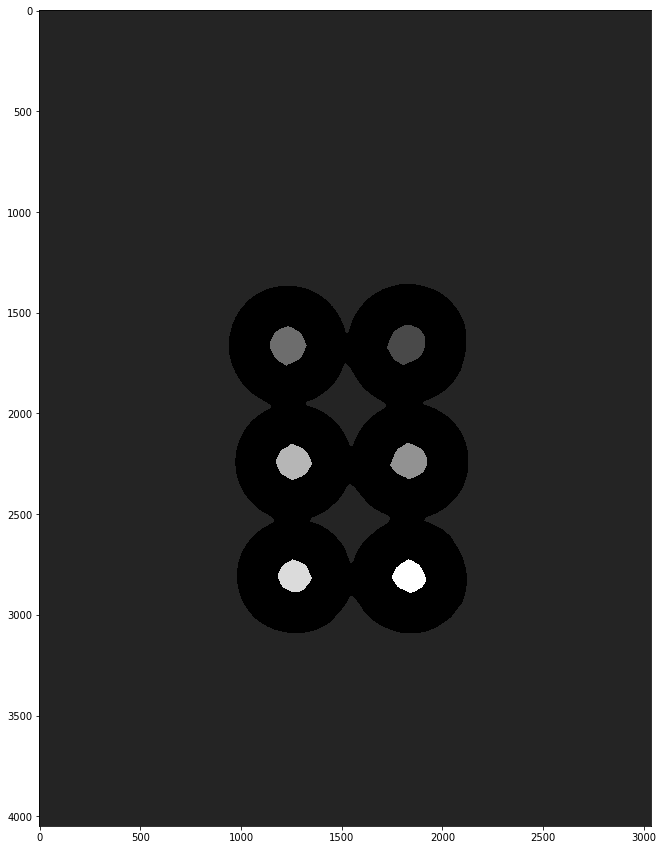

In [43]:
ret, markers = cv.connectedComponents(coins_foreground)
markers += 1 # add to don't get confused with the 0's
markers[unkown_area==255] = 0
display(markers)

##### 3. Do the watershed

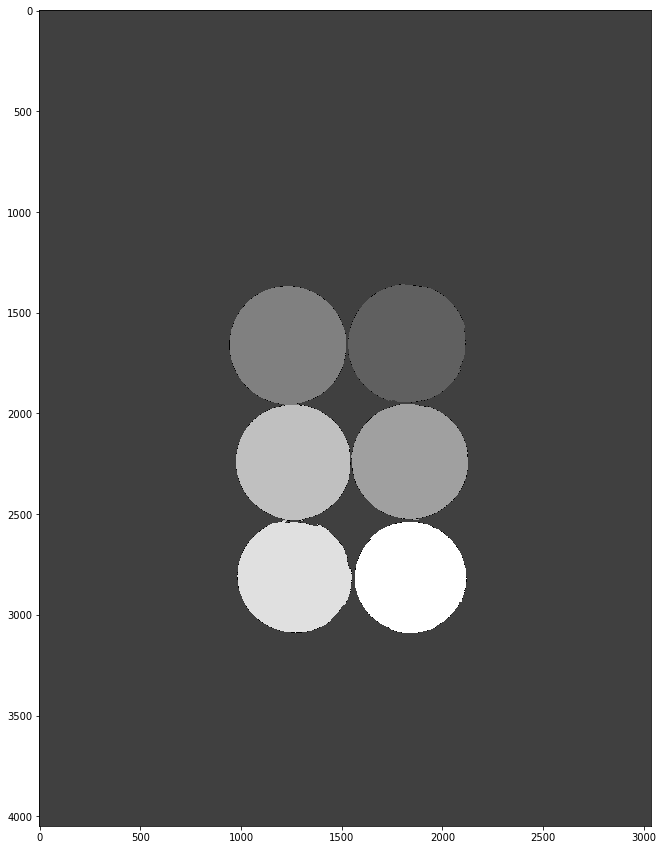

In [44]:
coins_watershed = cv.watershed(coins_img, markers)
display(coins_watershed)

### Find the Contours

In [45]:
# in openCv 4 is only 2 -> contours, hierarchy
image, contours, hierarchy = cv.findContours(coins_watershed.copy(), cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)

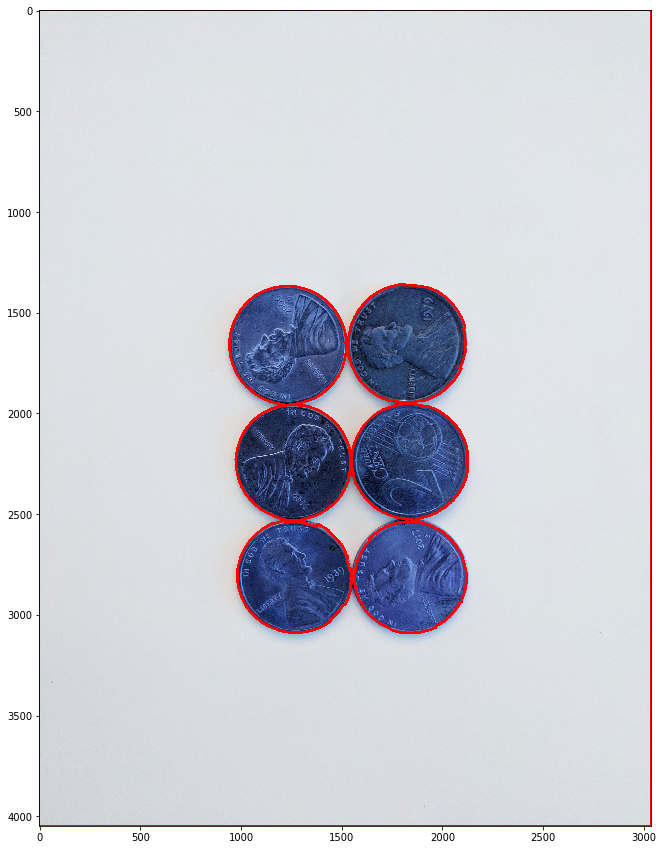

In [46]:
coins_img_copy = coins_img.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] == -1:
        cv.drawContours(coins_img_copy, contours, i, (255,0,0), 10)
display(coins_img_copy)